# MNIST Image Classification with TensorFlow

This notebook demonstrates how to implement a simple linear image model on [MNIST](http://yann.lecun.com/exdb/mnist/) using the [tf.keras API](https://www.tensorflow.org/versions/r2.0/api_docs/python/tf/keras). It builds the foundation for this <a href="mnist_models.ipynb">companion notebook</a>, which explores tackling the same problem with other types of models such as DNN and CNN.

This notebook uses TF2.0
Please check your tensorflow version using the cell below. If it is not 2.0, please run the pip line below and restart the kernel.

In [1]:
import tensorflow as tf

print(tf.__version__)

2.0.0-beta1


In [2]:
!pip freeze | grep tensorflow==2.0.0b1 || pip install tensorflow==2.0.0b1

tensorflow==2.0.0b1


In [3]:
import os
import shutil
import unittest

import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Flatten, Softmax
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard

## Exploring the data

The MNIST dataset is already included in tensorflow through the keras datasets module. Let's load it and get a sense of the data.

In [4]:
mnist = tf.keras.datasets.mnist.load_data()
(x_train, y_train), (x_test, y_test) = mnist

In [5]:
HEIGHT, WIDTH = x_train[0].shape
NCLASSES = tf.size(tf.unique(y_train).y)
print("Image height x width is", HEIGHT, "x", WIDTH)
tf.print("There are", NCLASSES, "classes")

Image height x width is 28 x 28
There are 10 classes


Each image is 28 x 28 pixels and represents a digit from 0 to 9. These images are black and white, so each pixel is a value from 0 (white) to 255 (black). Raw numbers can be hard to interpret sometimes, so we can plot the values to see the handwritten digit as an image.

The label for image number 12 is 9


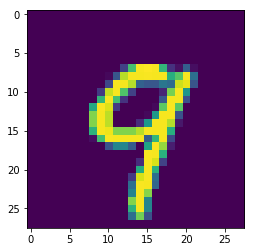

In [6]:
IMGNO = 12
# Uncomment to see raw numerical values.
# print(x_test[IMGNO])
plt.imshow(x_test[IMGNO].reshape(HEIGHT, WIDTH));
print("The label for image number", IMGNO, "is", y_test[IMGNO])

## Define the model
Let's start with a very simple linear classifier. This was the first method to be tried on MNIST in 1998, and scored an 88% accuracy. Quite ground breaking at the time!

We can build our linear classifer using the [tf.keras API](https://www.tensorflow.org/versions/r2.0/api_docs/python/tf/keras), so we don't have to define or initialize our weights and biases. This happens automatically for us in the background. We can also add a softmax layer to transform the logits into probabilities. Finally, we can compile the model using categorical crossentropy in order to strongly penalize high probability predictions that were incorrect.

When building more complex models such as DNNs and CNNs our code will be more readable by using the [tf.keras API](https://www.tensorflow.org/versions/r2.0/api_docs/python/tf/keras). Let's get one working so we can test it and use it as a benchmark.

In [7]:
def linear_model():
    model = Sequential([
        Flatten(),
        Dense(NCLASSES),
        Softmax()
    ])

    model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    
    return model

## Write Input Functions

As usual, we need to specify input functions for training and evaluating. We'll scale each pixel value so it's a decimal value between 0 and 1 as a way of normalizing the data.

In [8]:
BUFFER_SIZE = 5000
BATCH_SIZE = 100

TRAIN_KEY = tf.estimator.ModeKeys.TRAIN
EVAL_KEY = tf.estimator.ModeKeys.EVAL


def scale(image, label):
    image = tf.cast(image, tf.float32)
    image /= 255
    return image, label


def load_dataset(mode):
    dataset = (x_train, y_train) if mode == TRAIN_KEY else (x_test, y_test)
    dataset = tf.data.Dataset.from_tensor_slices(dataset)
    dataset = dataset.map(scale).batch(BATCH_SIZE)
    if mode == TRAIN_KEY:
        dataset = dataset.shuffle(BUFFER_SIZE).repeat()
    return dataset

In [9]:
def create_shape_test(key):
    dataset = load_dataset(key)
    data_iter = dataset.__iter__()
    (images, labels) = data_iter.get_next()
    expected_image_shape = (BATCH_SIZE, HEIGHT, WIDTH)
    expected_label_shape = (BATCH_SIZE)
    assert(images.shape == expected_image_shape)
    assert(labels.shape == expected_label_shape)
    print("Test for", key, "passed!")


create_shape_test(TRAIN_KEY)
create_shape_test(EVAL_KEY)

Test for train passed!
Test for eval passed!


Time to train the model! The original MNIST linear classifier had an error rate of 12%. Let's use that to sanity check that our model is learning.

In [10]:
NUM_EPOCHS = 10
STEPS_PER_EPOCH = 100

model = linear_model()
train_data = load_dataset(TRAIN_KEY)
validation_data = load_dataset(EVAL_KEY)

OUTDIR = "mnist/linear_keras"
checkpoint_path = '{}/checkpoints/mnist'.format(OUTDIR)
checkpoint_callback = ModelCheckpoint(
    checkpoint_path, save_weights_only=True, verbose=1)
tensorboard_callback = TensorBoard(log_dir=OUTDIR)

history = model.fit(
    train_data, 
    validation_data=validation_data,
    epochs=NUM_EPOCHS, 
    steps_per_epoch=STEPS_PER_EPOCH,
    verbose=2,
    callbacks=[checkpoint_callback, tensorboard_callback]
)

Epoch 1/10


W0918 21:42:53.459595 139790080771840 deprecation.py:323] From /home/jupyter/.local/lib/python3.5/site-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



Epoch 00001: saving model to mnist/linear_keras/checkpoints/mnist
100/100 - 15s - loss: 1.2729 - accuracy: 0.5082 - val_loss: 0.7741 - val_accuracy: 0.8350
Epoch 2/10

Epoch 00002: saving model to mnist/linear_keras/checkpoints/mnist
100/100 - 1s - loss: 0.6556 - accuracy: 0.8473 - val_loss: 0.5504 - val_accuracy: 0.8728
Epoch 3/10

Epoch 00003: saving model to mnist/linear_keras/checkpoints/mnist
100/100 - 1s - loss: 0.5177 - accuracy: 0.8731 - val_loss: 0.4649 - val_accuracy: 0.8864
Epoch 4/10

Epoch 00004: saving model to mnist/linear_keras/checkpoints/mnist
100/100 - 1s - loss: 0.4903 - accuracy: 0.8603 - val_loss: 0.4187 - val_accuracy: 0.8931
Epoch 5/10

Epoch 00005: saving model to mnist/linear_keras/checkpoints/mnist
100/100 - 1s - loss: 0.4116 - accuracy: 0.8897 - val_loss: 0.3891 - val_accuracy: 0.9002
Epoch 6/10

Epoch 00006: saving model to mnist/linear_keras/checkpoints/mnist
100/100 - 1s - loss: 0.4150 - accuracy: 0.8845 - val_loss: 0.3697 - val_accuracy: 0.9053
Epoch 7/

In [11]:
BENCHMARK_ERROR = .12
BENCHMARK_ACCURACY = 1 - BENCHMARK_ERROR

accuracy = history.history['accuracy']
loss = history.history['loss']
    
assert(accuracy[-1] > BENCHMARK_ACCURACY)
print("Test to beat benchmark accuracy passed!")
        
assert(accuracy[0] < accuracy[1])
assert(accuracy[1] < accuracy[-1])
print("Test model accuracy is improving passed!")
    
assert(loss[0] > loss[1])
assert(loss[1] > loss[-1])
print("Test loss is decreasing passed!")

Test to beat benchmark accuracy passed!
Test model accuracy is improving passed!
Test loss is decreasing passed!


## Evaluating Predictions

Let's check Tensorboard to visually see how the model's accuracy and loss change over time. If running on a Deep Learning VM, wait for

`TensorBoard <version> at http://<notebook name>:6006/`

to appear, then go to File > New Launcher. Click on Tensorboard under "Other".
Interrupt the kernel when you are ready to continue.

In [12]:
os.environ["OUTDIR"] = OUTDIR

In [13]:
!tensorboard --logdir=$OUTDIR --port=6006

TensorBoard 1.14.0a20190603 at http://tf2-test:6006/ (Press CTRL+C to quit)
^C


Were you able to get an accuracy of over 90%? Not bad for a linear estimator! Let's make some predictions and see if we can find where the model has trouble. Change the range of values below to find incorrect predictions, and plot the corresponding images. What would you have guessed for these images?

In [14]:
image_numbers = range(0, 10, 1)  # Change me, please.

def load_prediction_dataset():
    dataset = (x_test[image_numbers], y_test[image_numbers])
    dataset = tf.data.Dataset.from_tensor_slices(dataset)
    dataset = dataset.map(scale).batch(len(image_numbers))
    return dataset

predicted_results = model.predict(load_prediction_dataset())
for index, prediction in enumerate(predicted_results):
    predicted_value = np.argmax(prediction)
    actual_value = y_test[image_numbers[index]]
    if actual_value != predicted_value:
        print("image number: " + str(image_numbers[index]))
        print("the prediction was " + str(predicted_value))
        print("the actual label is " + str(actual_value))
        print("")

image number: 8
the prediction was 6
the actual label is 5



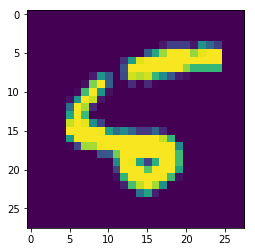

In [15]:
bad_image_number = 8
plt.imshow(x_test[bad_image_number].reshape(HEIGHT, WIDTH));

It's understandable why the poor computer would have some trouble. Some of these images are difficult for even humans to read. Ready for the next challenge? <a href="mnist_models.ipynb">Click here</a> to super charge our models with human-like vision.

## Bonus Exercise

Want to push your understanding further? Instead of using Keras'es built in layers, try repeating the above exercise with your own [custom layers](https://www.tensorflow.org/tutorials/eager/custom_layers).

<pre>
# Copyright 2017 Google Inc. All Rights Reserved.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#      http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
</pre>